# Detecting RF Modulations in TIme Series Data using a CNN

Whether out of personal curiousity or a professional interest in signal analysis, detecting the modulation of a signal in a spectrum is a valuable capability. Until recently, such detection was effected by expert knowledge of modulations, channel effects, etc. Learning to classify modulations by applying convolutional neural networks against complex-sampled, time domain RF signals requires no expert knowledge or techniques outside of those common to designing effective machine learning algorithms.

In this exercise, we'll create a ConvNet to learn how to classify modulations with no prior knowledge of modulation schemes or channel impairments. We'll feed the network 128 complex time series IQ samples per example (sampled around 1 Ms/s) at various signal to noise ratios and with various signal impairments as would be typical of a signal transmitted through various RF environments. The [dataset](https://radioml.com/ds/2016.10/RML2016.10a_dict.dat.bz2) also contains labels for the modulation of each of the examples and we'll use that to carry out this supervised learning experiment.

This exercise is based on a [paper](https://arxiv.org/pdf/1602.04105v3.pdf) written by Timothy O'Shea, Johnathan Corgan and T. Charles Clancy and [accompanying code](https://github.com/radioML/examples/blob/master/modulation_recognition/RML2016.10a_VTCNN2_example.ipynb)

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import np_utils
from keras.utils.data_utils import get_file

import os, numpy as np, pandas as pd, bz2

In [25]:
# fix random seed for reproducibility
seed = 43
np.random.seed(seed)
datafile_path = 'RML2016.10a_dict.dat'
show_confusion_plots = False


def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1


def download_dataset():
    if (os.path.exists(datafile_path)):
        print("dataset already on filesystem")
        return
    print("need to create dataset on filesystem")
    
    compressed_path = 'RML2016.10a_dict.dat.bz2'
    if not (os.path.exists(compressed_path)):
        print("downloading and extracting radioml dataset...")
        try:
            compressed_path = get_file(compressed_path, origin='https://radioml.com/ds/2016.10/RML2016.10a_dict.dat.bz2')
        except:
            print('Error downloading dataset, please download manually:\n')
            raise
        
    print("writing uncompressed dataset")
    with open(compressed_path, 'rb') as source, open(datafile_path, 'wb') as dest:
        dest.write(bz2.decompress(source.read()))
    return


def prepared_dataset(percent_training=0.7):
    if not (os.path.exists(datafile_path)):
        download_dataset()
    
    # dataset format: {('mod type', SNR): np.array(nvecs_per_key, 2, vec_length), ...}
    Xd = pd.read_pickle(datafile_path)
    snrs, modulations = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
    num_modulations = len(modulations)
    
    X = []  
    lbl = []
    
    for mod in modulations:
        for snr in snrs:
            X.append(Xd[(mod,snr)])
            for i in range(Xd[(mod,snr)].shape[0]):
                lbl.append((mod,snr))
    
    X = np.vstack(X)
    
    # Partition the data
    # into training and test sets of the form we can train/test on 
    # while keeping SNR and Mod labels handy for each
    n_examples = X.shape[0]
    n_train = n_examples * percent_training
    train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
    test_idx = list(set(range(0,n_examples))-set(train_idx))
    
    X_train = X[train_idx]
    X_test =  X[test_idx]

    Y_train = to_onehot(list(map(lambda x: modulations.index(lbl[x][0]), train_idx)))
    Y_test = to_onehot(list(map(lambda x: modulations.index(lbl[x][0]), test_idx)))
    
    return (X_train, Y_train, X_test, Y_test, modulations, snrs, lbl, test_idx)

# Why a ConvNet?

A CNN is tolerant of typical RF channel variances such as time shifting, mixing and scaling in that the convolutional layers have a receptive field (or kernel) that is moved over the input, thereby learning specific features of the input without regard to that feature's position in the input. This learned invariance is critical because recovering transmitted symbols relies on nullifying to the greatest extent the channel effects on the original signal.

A future exercise would be to examine the effect of adding pooling layers after the convolution layers to see if they increase the tolerance of channel impairments to improve the accuracy at lower SNRs.

In [26]:
def rf_mod_model(in_shape=None, dropout=0.5, num_modulations=None):
    model = Sequential()
    model.add(Reshape([1] + list(in_shape), input_shape=in_shape))
    model.add(ZeroPadding2D((0, 2), dim_ordering='th'))
    model.add(Convolution2D(256, 1, 3, border_mode='valid', activation='relu', dim_ordering='th'))
    model.add(Dropout(dropout))
    model.add(ZeroPadding2D((0, 2), dim_ordering='th'))
    model.add(Convolution2D(128, 2, 3, activation='relu', dim_ordering='th'))
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_modulations, activation='softmax'))
    model.add(Reshape([num_modulations]))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [27]:
batch=1000
weights_filepath = "rf_mod_classifier_cnn_weights.h5"

(X_train, y_train, X_test, y_test, mods, snrs, lbl, test_idx) = prepared_dataset()
input_shape = list(X_train.shape[1:])
print (X_train.shape, input_shape)

model = rf_mod_model(in_shape=input_shape, num_modulations=len(mods), dropout=0.6)
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    nb_epoch=100,
                    batch_size=batch,
                    verbose=2,
                    callbacks = [ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'), 
                                 #EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
                                ]
                   )

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("\nOverall %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:59: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(154000, 2, 128) [2, 128]
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
reshape_5 (Reshape)              (None, 1, 2, 128)     0           reshape_input_3[0][0]            
____________________________________________________________________________________________________
zeropadding2d_5 (ZeroPadding2D)  (None, 1, 2, 132)     0           reshape_5[0][0]                  
____________________________________________________________________________________________________
convolution2d_5 (Convolution2D)  (None, 256, 2, 130)   1024        zeropadding2d_5[0][0]            
____________________________________________________________________________________________________
dropout_7 (Dropout)              (None, 256, 2, 130)   0           convolution2d_5[0][0]            
_________________________________________________________________

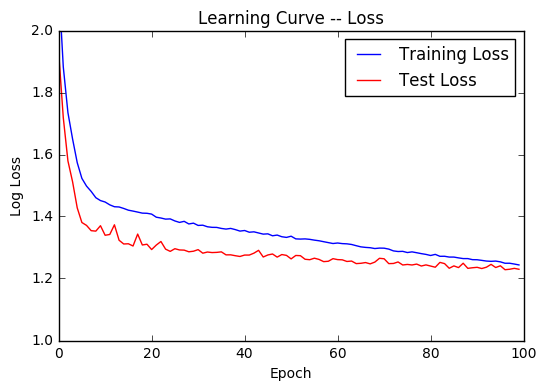

In [32]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Learning Curve -- Loss")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.ylim((1.0, 2.0))
 
# Plot the loss for training and testing sets
train_loss_data = history.history['loss']
test_loss_data = history.history['val_loss']
plt.plot(train_loss_data, color="b", label='Training Loss')
plt.plot(test_loss_data, color="r", label='Test Loss')

# Draw the plot and reset the y-axis
plt.legend(loc="best")
plt.draw()
plt.show()

In [33]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return

# Plot confusion matrix
num_mods = len(mods)
test_Y_hat = model.predict(X_test, batch_size=batch)
conf = np.zeros([num_mods, num_mods])
confnorm = np.zeros([num_mods,num_mods])
for i in range(0,X_test.shape[0]):
    j = list(y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,num_mods):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
plot_confusion_matrix(confnorm, labels=mods)

In [34]:
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    matching_snr_indices = np.where(np.array(test_SNRs)==snr)
    test_X_i = X_test[matching_snr_indices]
    test_Y_i = y_test[matching_snr_indices]

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([num_mods,num_mods])
    confnorm = np.zeros([num_mods,num_mods])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,num_mods):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
    if (show_confusion_plots):
        plt.figure()
        plot_confusion_matrix(confnorm, labels=mods, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
        plt.draw()
        plt.show()
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    acc[snr] = 1.0*cor/(cor+ncor)

# Well, how does it do?

A random guess between 11 choices would result in a being right 9.1% of the time. From the plot below, we can see that for very low SNRs (-20dB to -14dB), the network essentially makes a random guess as there's not enough information for the network to distinguish the signal from noise. The performance of the CNN picks up sharply at -12dB and continues to rise to around 80% for SNRs >= 0dB. The results published by Tim O'Shea et al show an accuracy around 90% at the higher SNRs, and I'm not sure why there's a discrepancy between my results and theirs.

The performance I achieved is below the state of the art expert-based systems. Even so, I count this as an impressive result for a system that has no prior knowledge of expert approaches to modulation detection.

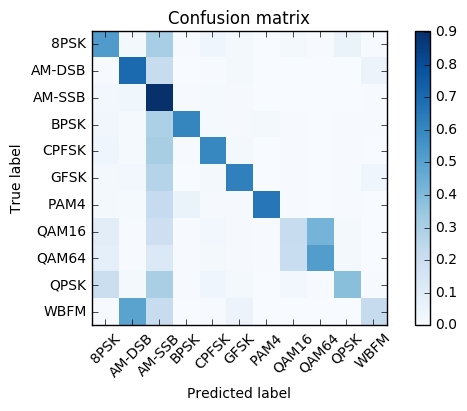

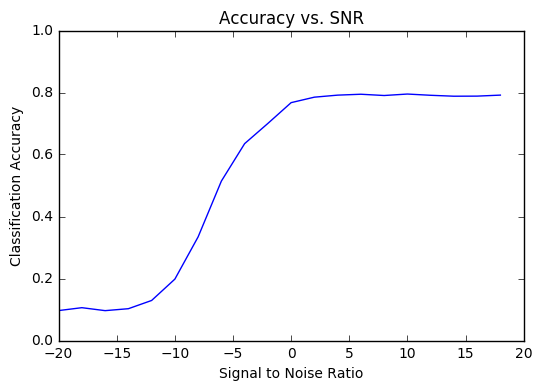

In [35]:
plt.figure()
plt.title("Accuracy vs. SNR")
plt.ylim((0.0, 1.0))

plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
 
plt.draw()
plt.show()

For the record, here are the raw accuracy numbers for future reference:

In [38]:
print (acc)

{0: 0.7672917307101137, 16: 0.78831246273106736, 2: 0.78493975903614455, 4: 0.7914919113241462, 6: 0.79438135086670647, 8: 0.79028765852149707, 12: 0.79100922893718373, 10: 0.79501973883996357, -20: 0.096539162112932606, 18: 0.79156626506024097, -18: 0.10585723001830384, -16: 0.096298525428829371, -14: 0.10257948410317937, -12: 0.12913191226444237, 14: 0.7880254006652555, -10: 0.19801365611421479, -8: 0.33433463502553318, -6: 0.5142428785607196, -4: 0.63501213592233008, -2: 0.70021678538247134}
